In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Downloads/notebooks/dynamics_tutorial/plain_samples/rocket`
Precompiling project...
  ✓ PackageCompiler
  1 dependency successfully precompiled in 5 seconds. 8 already precompiled.


In [4]:
using ModelingToolkit, LinearAlgebra
using GLMakie
using ControlSystemsBase
using DifferentialEquations
# using Plots

## Utilities

In [5]:
# create custom rotation matrix
R_2D(θ::Float64) = [cos(θ) -sin(θ); sin(θ) cos(θ)];


## Dynamics using DifferentialEquationsjl

In [6]:
#Define the problem
function rocket(dx, X, params, t)

    # g = params["g"]
    m, g, l, I_zz = params
    g_vec = [0;g]
    
#     # control input [T, phi]
#     u = [9.81,0.0]
#     # control variables
#     T = u[1];
#     ϕ = u[2];
    
    # compute control action
    U = [0,0]
    T = U[1];
    ϕ = U[2];

    # get the state
    x = X[1]
    z = X[2]
    θ = X[3]
    ẋ = X[4]
    ż = X[5]
    θ̇ = X[6]
    
    # disturbance moddel
    C_D = 0.75;
    v_wind = 0.2;
    A_ref = 0.54 
    f_wind = C_D *  A_ref * [cos(θ); 0] * v_wind
    
#     println("Wind:", f_wind)
    
    
    # translation E.O.M
    f = [T*sin(ϕ); T*cos(ϕ)]
    (ẍ, z̈) = R_2D(θ)*f + g_vec 

    # rotational E.O.M
    θ̈ = -(l*T*sin(ϕ)) / I_zz
    
#     # first order response of gimbal
#     ϕ̇ = -(1 / 0.05) * (ϕ_desired - ϕ)
    
    # prevent rocket from going into ground (negative z coordinate)
    if z<0
        z = 0
    end
    
    dx[1], dx[2], dx[3] = ẋ, ż, θ̇
    dx[4], dx[5], dx[6] = ẍ, z̈, θ̈
end

rocket (generic function with 1 method)

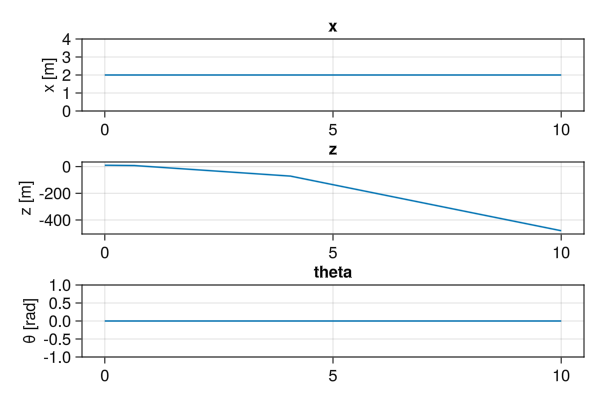

In [10]:
# parameters [m, g, l, I_zz]
params = [1.0, -9.81, 0.5, 0.3]

#Initial Conditions
u₀ = [2,10,0,0,0,0];
tspan = (0.0, 10);

#Pass to solvers
prob = ODEProblem(rocket, u₀, tspan, params);
sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8);

rocket_plot_normal(sol)

### Plotting

In [9]:
function rocket_plot_normal(sol::ODESolution)
    fig = Figure(resolution=(600, 400))

    x_ax = Axis(fig[1, 1], title="x")
    z_ax = Axis(fig[2, 1], title="z")
    theta_ax = Axis(fig[3, 1], title="theta")

    lines!(x_ax, sol.t, sol[1, :])
    lines!(z_ax, sol.t, sol[2, :])
    lines!(theta_ax, sol.t[:], sol[3, :])

    x_ax.ylabel = "x [m]"
    z_ax.ylabel = "z [m]"
    theta_ax.ylabel = "θ [rad]"

    rowgap!(fig.layout, 1)

    fig
end

function rocket_plot(sol::ODESolution)
    fig = Figure(resolution=(600, 400))

    x_ax = Axis(fig[1, 1], title="x")
    z_ax = Axis(fig[2, 1], title="z")
    theta_ax = Axis(fig[3, 1], title="theta")

    lines!(x_ax, sol.t, sol[x])
    lines!(z_ax, sol.t, sol[z])
    lines!(theta_ax, sol.t[:], sol[θ])

    x_ax.ylabel = "x [m]"
    z_ax.ylabel = "z [m]"
    theta_ax.ylabel = "θ [rad]"
    theta_ax.ylabel = "Thrust [N]"

    rowgap!(fig.layout, 1)

    fig
end

function rocket_plot_lsim(t, x, uout)
    fig = Figure(resolution=(600, 600), title="LQR controller on nominal system")

    x_ax = Axis(fig[1, 1], title="x")
    z_ax = Axis(fig[2, 1], title="z")
    theta_ax = Axis(fig[3, 1], title="theta")
    u1_ax = Axis(fig[4, 1], title="Thrust force")

    lines!(x_ax, collect(t), x[1,:])
    lines!(z_ax, collect(t), x[2,:])
    lines!(theta_ax, collect(t), x[3,:])
    
    lines!(u1_ax, collect(t), uout[1,:])

    x_ax.ylabel = "x [m]"
    z_ax.ylabel = "z [m]"
    theta_ax.ylabel = "θ [rad]"

    rowgap!(fig.layout, 1)

    fig
end

rocket_plot_lsim (generic function with 1 method)

# Using modelling toolkit

In [77]:
# define parameters and variables
@parameters l, I_zz, m

# state variables
@variables t, x(t), z(t), θ(t)

# control input
@variables T(t)=0 [input=true] ϕ(t)=0 [input=true] 

@constants g=-9.81

# define operators
D = Differential(t)

# dynamics equations
# gravity 
g_vec = [0;g]

# create custom rotation matrix
R_2D(θ::Real) = [cos(θ) -sin(θ); sin(θ) cos(θ)];

# disturbance moddel
C_D = 0.75;
C_M = 0.15 ;

v_wind = 0.2;
A_ref = 0.54 
f_wind = C_D *  A_ref * [cos(θ); 0] * v_wind
tau_wind = C_M *  A_ref * l * cos(θ) * v_wind

# force
f = [0; T*cos(ϕ)]

# translation E.O.M
# (ẍ, z̈) = (1/m)* R_2D(θ)*f + g_vec + f_wind
(ẍ, z̈) = (1/m)* R_2D(θ)*f + g_vec 

# rotational E.O.M
# θ̈ = -(l*T*sin(ϕ)) / I_zz + tau_wind
θ̈ = -(l*T*sin(ϕ)) / I_zz 


eqs = [D(D(x)) ~ ẍ, D(D(z)) ~ z̈, D(D(θ)) ~ θ̈]

# create ODESystem and simplify
@named sys_unsimplified = ODESystem(eqs)
sys = structural_simplify(sys_unsimplified );

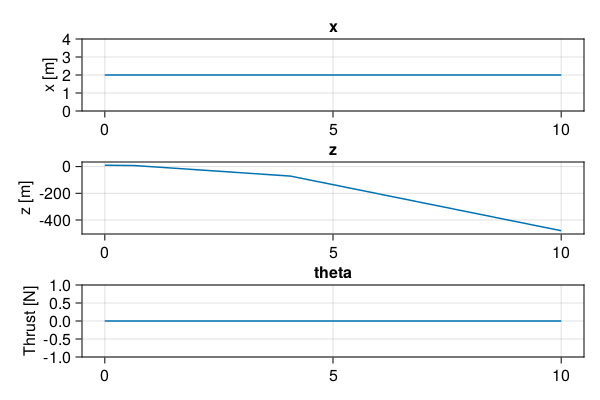

In [78]:
# initial conditions
u₀ = Dict(
    x => 2.0,
    z => 10.0,
    θ => 0.0,
    D(x) => 0.0,
    D(z) => 0.0,
    D(θ) => 0.0,
)

# parameter values
params = Dict(
    l => 0.5,
    I_zz =>0.3 ,
    m => 1.0,
)


#Pass to solver
tspan = (0.0, 10.0)
prob = ODEProblem(sys, u₀, tspan, params, jac=true)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

#plotting
rocket_plot(sol)

# Linearization

In [82]:
# vector of nonlinear eqns of motion
nonlinear_eq_vec = [D(x),
                    D(z), 
                    D(θ), 
                    equations(sys_unsimplified)[1].rhs,
                    equations(sys_unsimplified)[2].rhs,
                    equations(sys_unsimplified)[3].rhs]

state_vec = [x, z, θ, D(x), D(z), D(θ)]
control_vec = [T, ϕ]

# Calculate A,B matrices
A = Symbolics.jacobian(nonlinear_eq_vec, state_vec)
B = Symbolics.jacobian(nonlinear_eq_vec, control_vec)


# Linearize around equilibrium point

x₀ = Dict(
    D(θ) => 0.0,
    θ => 0.0,
    D(x) => 0.0,
    x => 0.0,
    D(z) => 0.0,
    z => 0.0
)

u₀ = Dict(
    T => 9.81,
    ϕ => 0.0
)

A = substitute(A, u₀);
A = substitute(A, x₀);
B = substitute(B, u₀);
B = substitute(B, x₀);

function convert_to_numeric(A::Array{Num})
    A_num = [i.val for i in A]
    A_num = convert(Array{Float64}, A_num)
    
    return A_num
end

# Assume that all states are measurable
C = [1 1 0 0 0 1]

1×6 Matrix{Int64}:
 1  1  0  0  0  1

In [93]:
# vector of nonlinear eqns of motion
nonlinear_eq_vec = [D(z), 
                    D(θ), 
                    equations(sys_unsimplified)[2].rhs,
                    equations(sys_unsimplified)[3].rhs]

state_vec = [z, θ, D(z), D(θ)]
control_vec = [T, ϕ]

# Calculate A,B matrices
A = Symbolics.jacobian(nonlinear_eq_vec, state_vec)
B = Symbolics.jacobian(nonlinear_eq_vec, control_vec)


# Linearize around equilibrium point

x₀ = Dict(
    D(θ) => 0.0,
    θ => 0.0,
    D(z) => 0.0,
    z => 0.0
)

u₀ = Dict(
    T => 9.81,
    ϕ => 0.0
)

A = substitute(A, u₀);
A = substitute(A, x₀);
B = substitute(B, u₀);
B = substitute(B, x₀);

function convert_to_numeric(A::Array{Num})
    A_num = [i.val for i in A]
    A_num = convert(Array{Float64}, A_num)
    
    return A_num
end

# Assume that all states are measurable
C = [1 1 1 1]

1×4 Matrix{Int64}:
 1  1  1  1

In [92]:
# Substitute parameters
A = substitute(A, params)
B = substitute(B, params)

A = convert_to_numeric(A)
B = convert_to_numeric(B)

Ts = 0.1
sys_d = ss(A, B, C, 0, Ts)

StateSpace{Discrete{Float64}, Float64}
A = 
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
B = 
 0.0    0.0
 0.0    0.0
 1.0    0.0
 0.0  -16.35
C = 
 1.0  1.0  1.0  1.0
D = 
 0.0  0.0

Sample Time: 0.1 (seconds)
Discrete-time state-space model

In [95]:
B

4×2 Matrix{Num}:
 0          0
 0          0
 1.0 / m    0.0
 0.0      (-9.81l) / I_zz

### LQR Controller

In [72]:
# Design controller
Q       = Diagonal([1,1,5,3,3,5]) # Weighting matrix for state
R       = Diagonal([10,2]) # Weighting matrix for input

# Compute LQR gain matrix
K      = lqr(Discrete, A,B,Q,R) # lqr(sys,Q,R) can also be used

2×6 Matrix{Float64}:
 5.50064e-30  3.45523e-34  -1.82538e-14  …  -6.25707e-18  7.22081e-16
 1.38571e-16  7.89842e-31  -0.00364568       2.49926e-17  3.46746e-15

In [141]:
# Simulation
u(x,t)  = -K*x  # Form control law (u is a function of t and x), a constant input disturbance is affecting the system from t≧2.5
t       = 0:Ts:5              # Time vector
x0      = [2,10,0.1,0,0,0]               # Initial condition

y, t, x, uout = lsim(sys_d,u,t,x0=x0)
fig = rocket_plot_lsim(t, x, uout)
save("lqr.pdf", fig) 

CairoMakie.Screen{PDF}


## Uncertainity modelling

In [41]:
# Create an uncertain Gaussian parameter
ω = 1 ± 0.1 

# # Create an uncertain uniform parameter
# ζ = 0.3..0.4 

1.0 ± 0.1 Particles{Float64, 2000}


In [126]:
uout

2×51 Matrix{Float64}:
 -1.5581e-15   2.39217e-7  -1.16878e-17  …  2.34551e-58  -1.16826e-68
 -4.58422e-5  -1.1692e-17  -3.44358e-7      3.13443e-68  -3.3764e-58